In [1]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold

In [2]:

# df_TagDesc = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\CSV\Not for Processing\TagDesc.csv')

# df_All_1 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_1o2.csv')
# df_All_2 = pd.read_csv(r'C:\Users\saust\OneDrive\Desktop\GitRepo\Project-OptiC4\1 Preprocess\Merge Data\contData_all_Avg_2o2.csv')
# # Concatenate (union) the dataframes
# df_All = pd.concat([df_All_1, df_All_2], ignore_index=True)

df_All = pd.read_csv(r'C:\Users\austinsh\Project-OptiC4\III Models\3 Model STEAM - FC55569\3 Feature Selection\filtered-out_5-9_corr.csv')

print(df_All.head())


                  Date  425_pct_Al     Al2O3  M_Value  C4_pct_Eth  C4_pct_H2O  \
0  2012-05-17 09:00:00    6.319560  11.41670  3.50773    2.554580     22.0531   
1  2012-05-17 10:00:00    6.319915  11.40835  3.50797    2.555935     22.0557   
2  2012-05-17 12:00:00    6.320970  11.39165  3.50869    2.560005     22.0636   
3  2012-05-18 08:00:00    6.328690  11.39165  3.51401    2.540370     22.0604   
4  2012-05-18 09:00:00    6.336060  11.40500  3.51910    2.514430     22.0484   

   HydWtr_pct_Ammonia  C4_pct_Hex  HydWtr_Na2O  Butanol  ...   LC55557  \
0            0.867508    0.670721     3.354160  30.3662  ...  66.31395   
1            0.864729    0.671059     3.306475  30.3662  ...  66.31395   
2            0.856391    0.672071     3.163420  30.6785  ...  66.31395   
3            0.811652    0.674174     2.238130  32.6454  ...  65.92560   
4            0.773793    0.675408     1.391475  32.6454  ...  65.92560   

    LC55568    LC90366   LC90368   PI55004   PI55020   TC55552   TC5

### Include

In [3]:
# selected_columns = ['Butanol', 
#                     'FC55569',
#                     'DI55152',
#                     '425 %Al',
#                     'TC55552',
#                     'FC55003',
#                     'LC55555',
#                     'FFC55553',
#                     'FFC55555',
#                     'TC55555',
#                     'TI55021',
#                     'PI55004',
#                     'FC55552'
#                     ]
# existing_columns = [col for col in selected_columns if col in df_All.columns]
# df_All = df_All[existing_columns]

# print(df_All.head())

In [4]:
# Set max columns to display
pd.set_option('display.max_columns', None)

### Exlcude

In [5]:
# List of columns to exclude to run XGboost feature selection
exclude_columns = [  'Date', 
                    'M_Value',
                    'HydWtr_pct_Ammonia',
                    'HydWtr_Na2O',

                    'PI55004',
                    'Decanol',
                    'LC55557',
                    'LC52572',
                    'LC55568',
                    'LC90368',
                    'LC55553',

                    'TC55552',
                    'FC55009',
                    'TC55555',
                    'FC55552',

                    'FFC55553', # Reiterating within this run, since it was the only one found.

                    # Should have processed these out earlier, but was assuming some Butanol as an adjuster
                    # # FFC55555 is s better predicter according to the XGB-FS
                    'Butanol',
                    'TI55021',
                    'TI40050'

            #      'C4_pct_Hex', 'HydWtr_Na2O',
            #       # No improvement after dropping:
            #      'TC55555'
            #    #   MSE Train	RMSE Train	R2 Train	MSE Test	RMSE Test	R2 Test
            #    #   7.935280	2.8169630	0.90869	12.1856	3.490801	   0.8677
                   
                   ]

# Create a new DataFrame without the excluded columnsd
df_All = df_All.drop(columns=exclude_columns)

In [6]:
df_All.columns

Index(['425_pct_Al', 'Al2O3', 'C4_pct_Eth', 'C4_pct_H2O', 'C4_pct_Hex',
       'DI55102', 'DI55152', 'DI55580', 'FC55003', 'FC55569', 'FC55576',
       'FFC55555', 'LC90366', 'PI55020'],
      dtype='object')

In [7]:
# df_All = df_All[df_All['Date'] > '2020-06-15 00:00:00']

In [8]:
# df_All.drop('Date', axis=1, inplace=True)

In [9]:
print(df_All.describe())

         425_pct_Al         Al2O3    C4_pct_Eth    C4_pct_H2O    C4_pct_Hex  \
count  40127.000000  40127.000000  40127.000000  40127.000000  40127.000000   
mean       6.133716     11.382607      1.213887     21.178645      0.471411   
std        0.228800      0.547831      0.691779      2.750323      0.241196   
min        5.270185      9.740945      0.030786      7.714985      0.000327   
25%        6.003510     11.095875      0.621701     18.843125      0.353947   
50%        6.135865     11.495850      1.103350     21.462900      0.447077   
75%        6.265830     11.719825      1.687807     23.275925      0.546428   
max        7.026215     12.879900      9.466675     34.151950      3.075880   

            DI55102       DI55152       DI55580       FC55003       FC55569  \
count  40127.000000  40127.000000  40127.000000  40127.000000  40127.000000   
mean       0.944657      0.932500      0.995820   5994.093426   6599.626128   
std        0.051564      0.028840      0.045932    

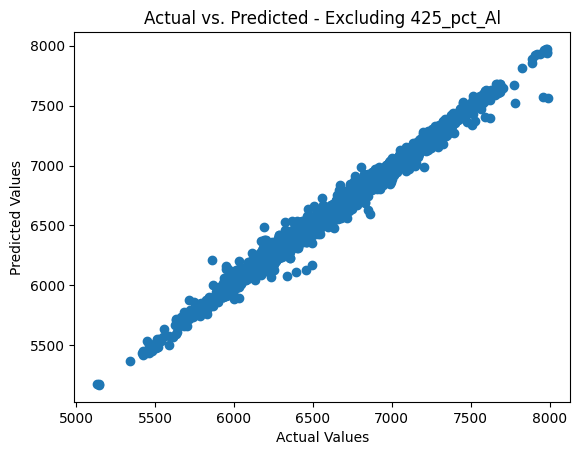

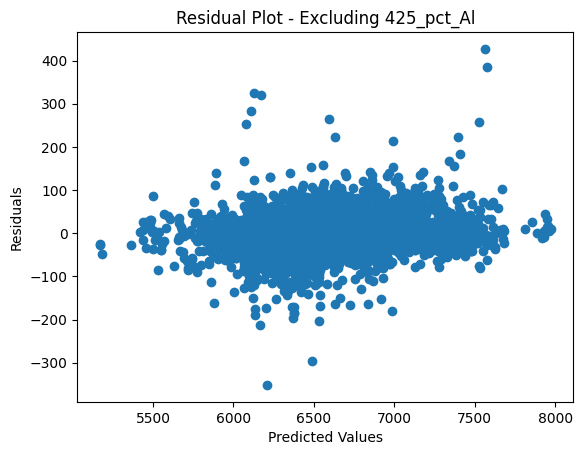

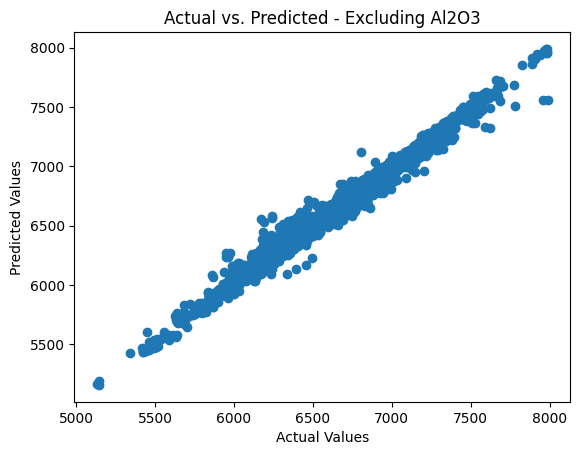

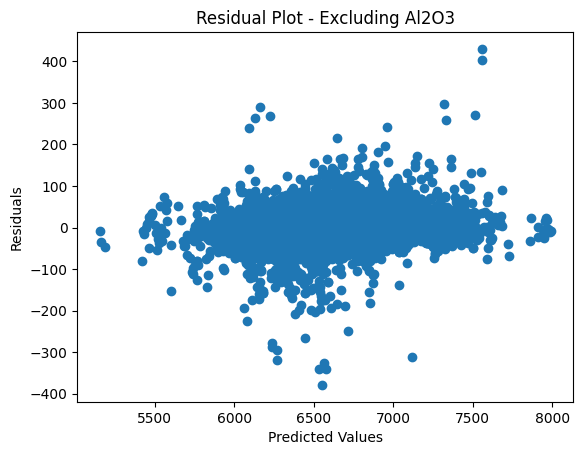

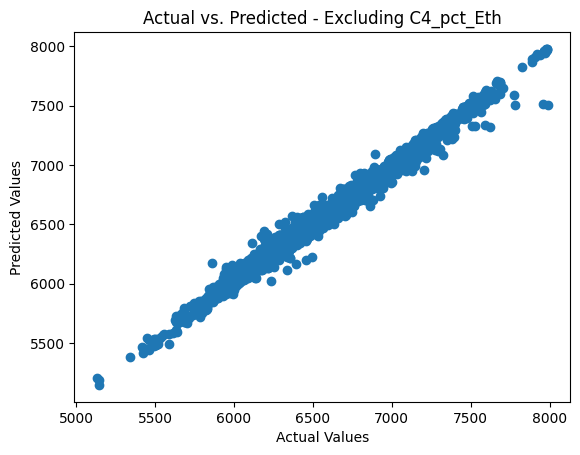

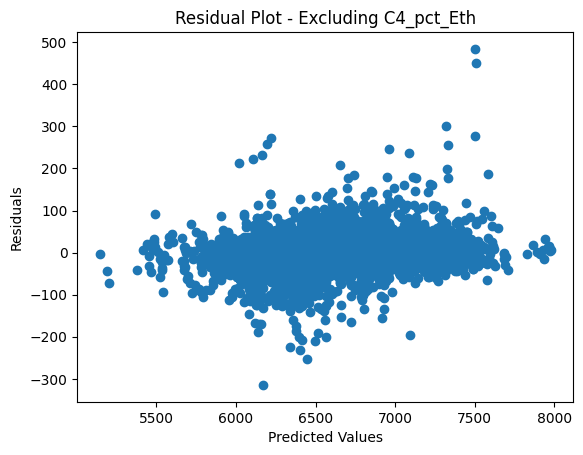

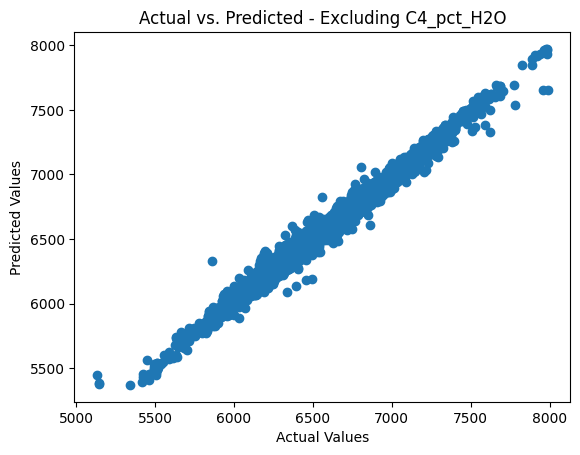

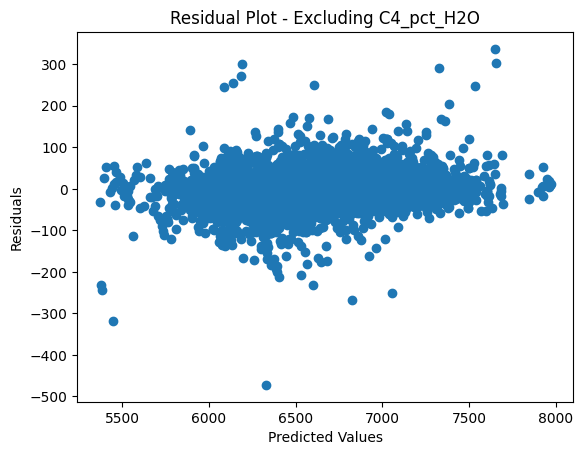

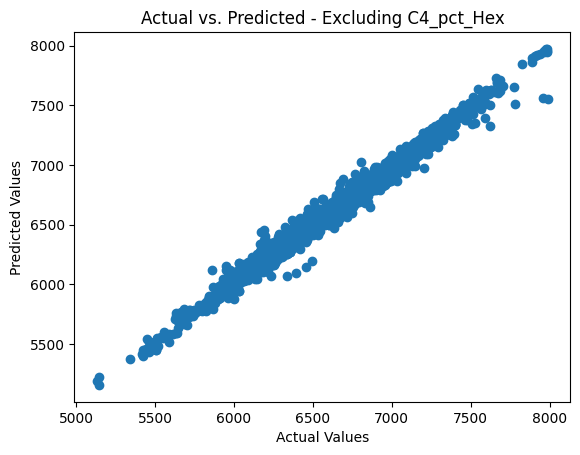

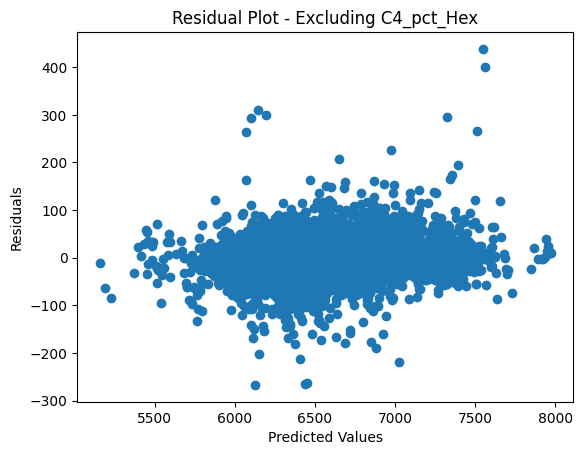

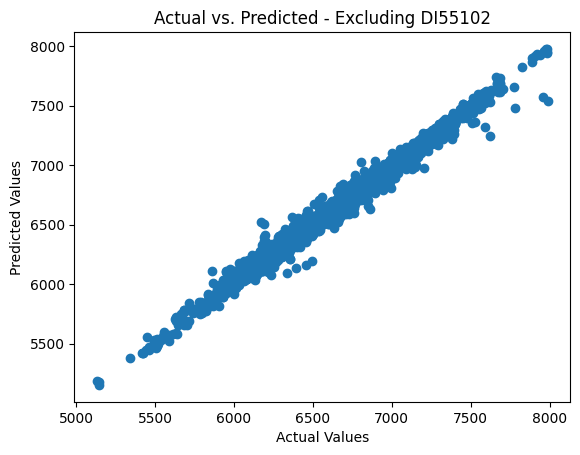

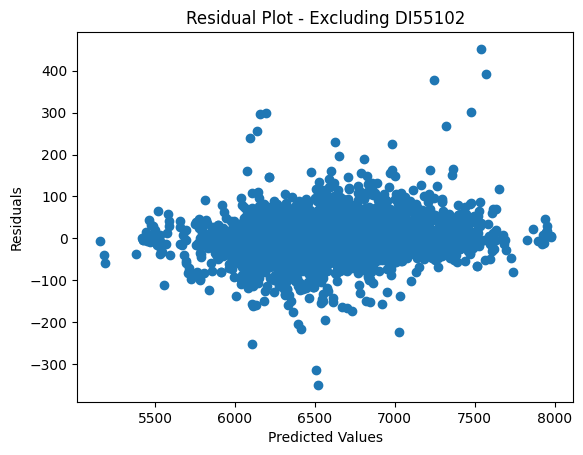

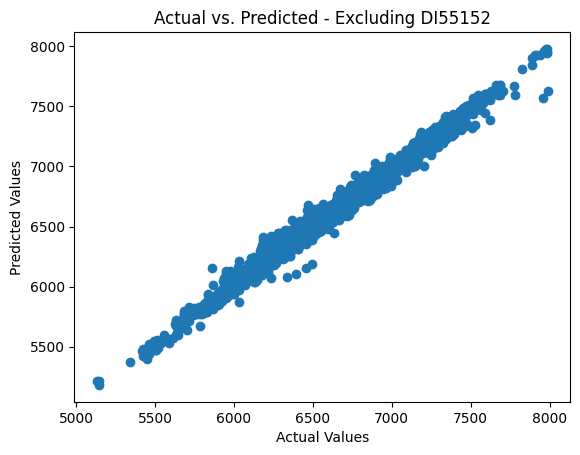

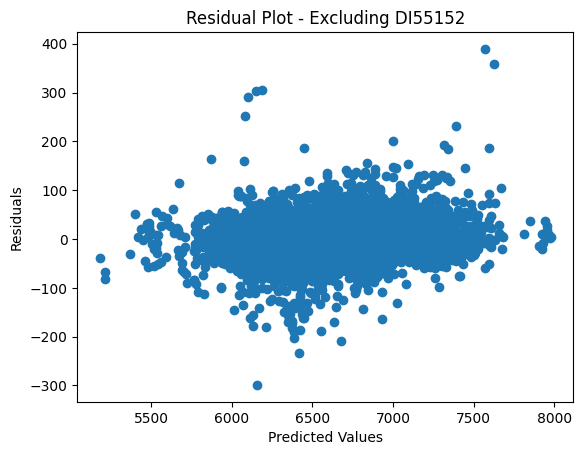

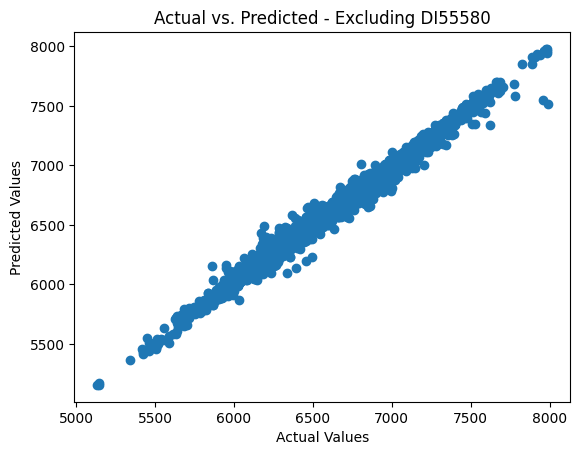

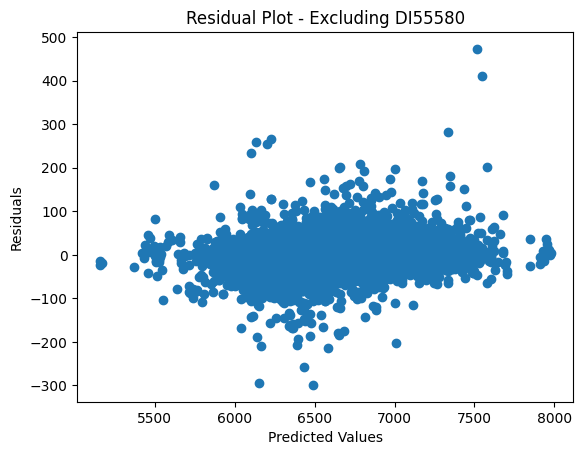

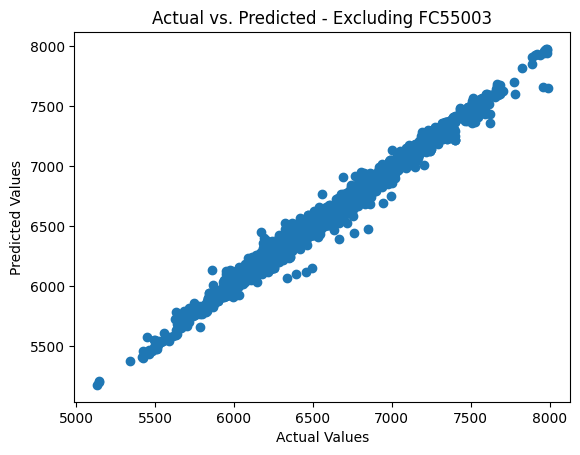

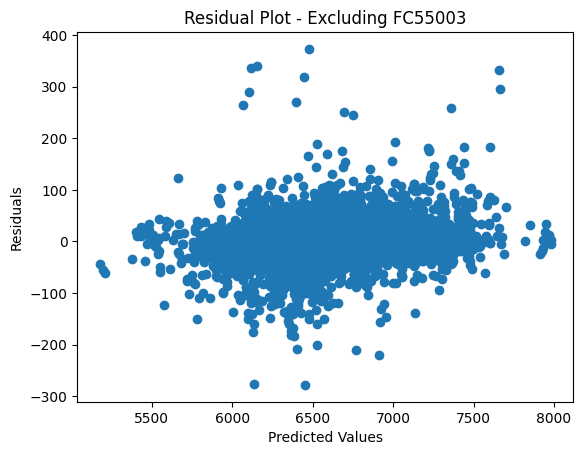

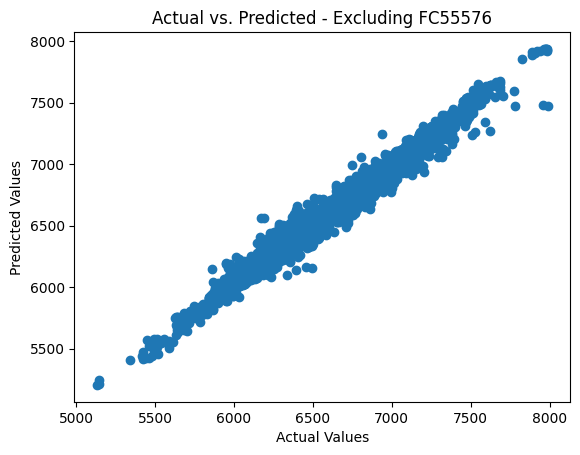

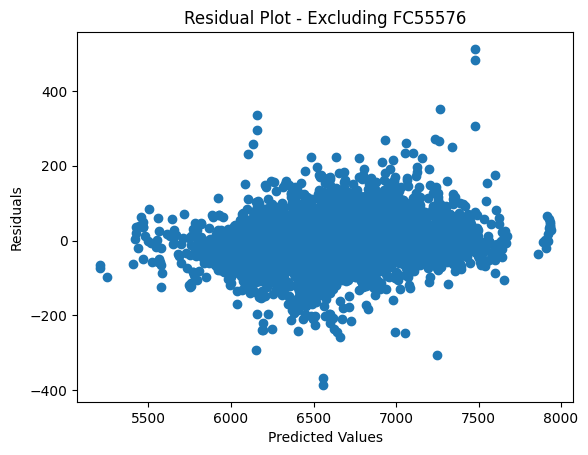

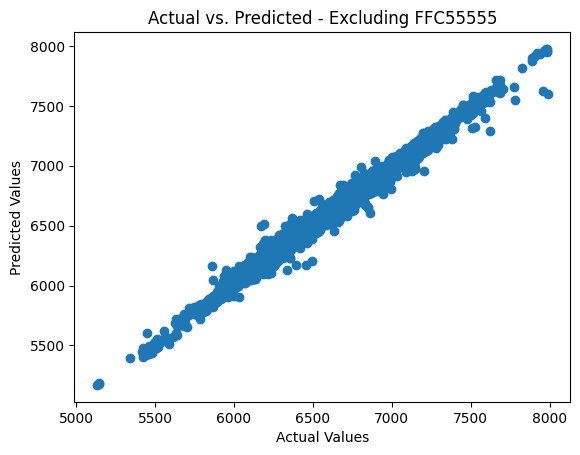

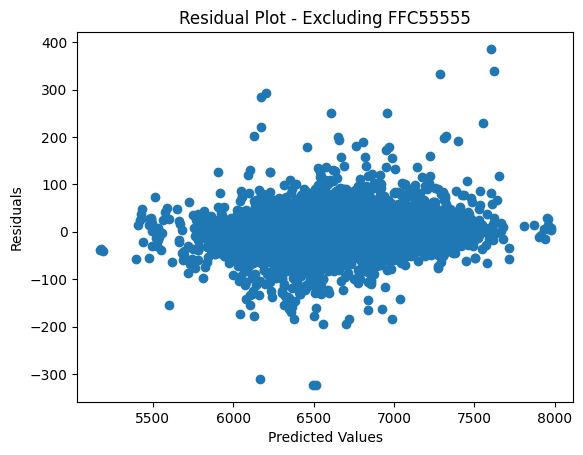

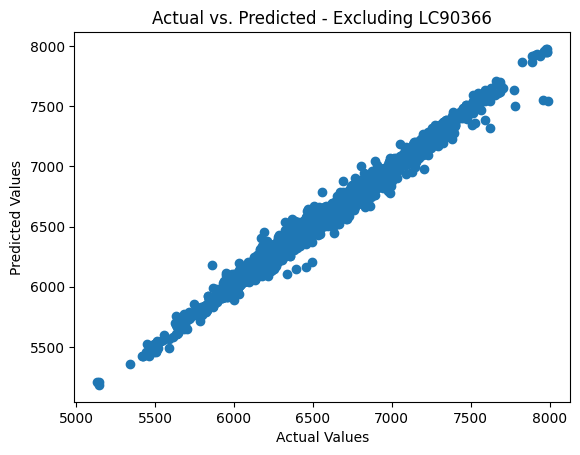

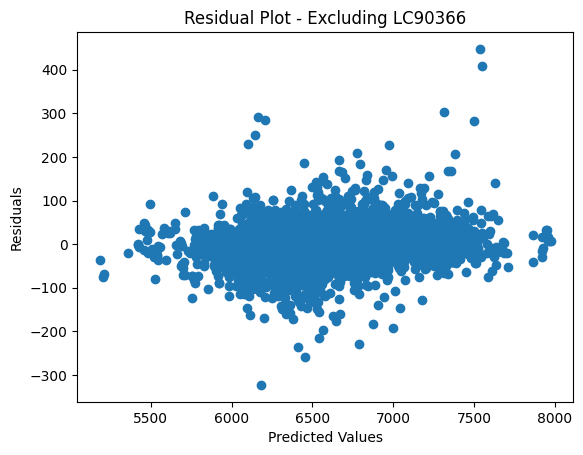

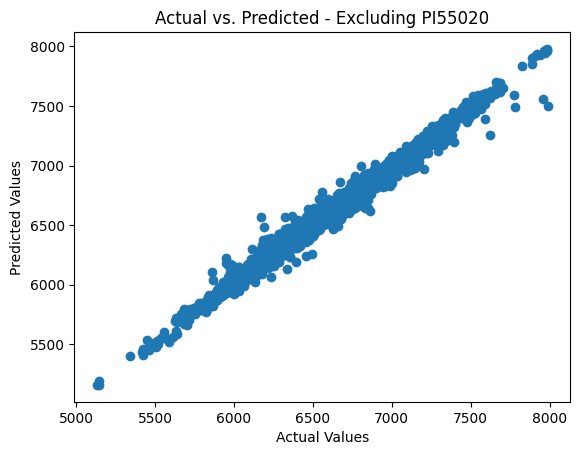

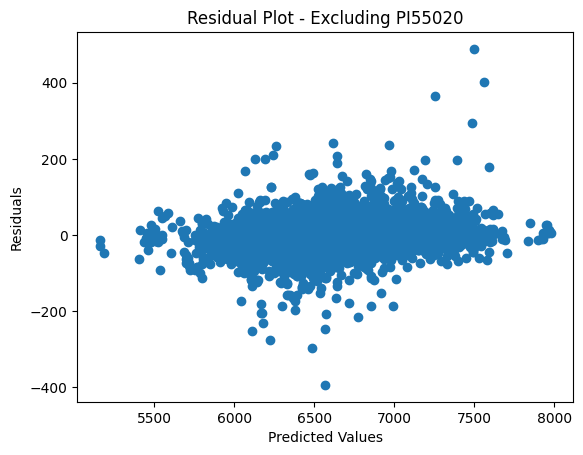

Feature Excluded: 425_pct_Al
MSE Train: 763.1132808939669
RMSE Train: 27.624505079620285
R2 Train: 0.9943659594582694
MSE Test: 1190.0713792194358
RMSE Test: 34.49741119590622
R2 Test: 0.9909617001937566


Feature Excluded: Al2O3
MSE Train: 933.8893113063157
RMSE Train: 30.55960260386767
R2 Train: 0.9931051255781779
MSE Test: 1551.8909457488608
RMSE Test: 39.394047085173426
R2 Test: 0.9882137694602212


Feature Excluded: C4_pct_Eth
MSE Train: 832.5580279243725
RMSE Train: 28.85408165103115
R2 Train: 0.9938532511488017
MSE Test: 1275.767889521375
RMSE Test: 35.71789312825401
R2 Test: 0.9903108562477694


Feature Excluded: C4_pct_H2O
MSE Train: 815.6093233293218
RMSE Train: 28.55887468597672
R2 Train: 0.9939783828837736
MSE Test: 1283.3885987551737
RMSE Test: 35.82441344607297
R2 Test: 0.9902529788330243


Feature Excluded: C4_pct_Hex
MSE Train: 784.7704796697792
RMSE Train: 28.013755186868096
R2 Train: 0.9942060650638483
MSE Test: 1270.127870185512
RMSE Test: 35.6388533792196
R2 Test: 0

In [10]:

def feature_iteration_model(df, target_column_name, plot_results=False):
    original_features = df.drop(target_column_name, axis=1).columns
    model_performance = {}

    for feature in original_features:
        X = df.drop([target_column_name, feature], axis=1)
        y = df[target_column_name]

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        xgb_model = xgb.XGBRegressor(
            objective ='reg:squarederror', 
            learning_rate=0.03,
            n_estimators=600,
            max_depth=7,
            subsample=0.9,
            colsample_bytree=0.8,
            gamma=2.0,
            alpha=0.2,
            reg_lambda=2,
            colsample_bylevel=0.8,
            colsample_bynode=0.7
        )
        xgb_model.fit(X_train, y_train)

        # Predict and evaluate on training data
        y_train_pred = xgb_model.predict(X_train)
        mse_train = mean_squared_error(y_train, y_train_pred)
        rmse_train = np.sqrt(mse_train)
        r2_train = r2_score(y_train, y_train_pred)

        # Predict and evaluate on test data
        y_pred = xgb_model.predict(X_test)
        mse_test = mean_squared_error(y_test, y_pred)
        rmse_test = np.sqrt(mse_test)
        r2_test = r2_score(y_test, y_pred)

        # Store the metrics
        model_performance[feature] = {
            'MSE Train': mse_train,
            'RMSE Train': rmse_train,
            'R2 Train': r2_train,
            'MSE Test': mse_test,
            'RMSE Test': rmse_test,
            'R2 Test': r2_test
        }

        # Plotting (optional)
        if plot_results:
            plt.scatter(y_test, y_pred)
            plt.xlabel('Actual Values')
            plt.ylabel('Predicted Values')
            plt.title(f'Actual vs. Predicted - Excluding {feature}')
            plt.show()

            residuals = y_test - y_pred
            plt.scatter(y_pred, residuals)
            plt.xlabel('Predicted Values')
            plt.ylabel('Residuals')
            plt.title(f'Residual Plot - Excluding {feature}')
            plt.show()

    return model_performance

# Assuming your data is in df_All and you want to predict 'Butanol'
performance_without_each_feature = feature_iteration_model(df_All, 'FC55569', plot_results=True)

# Print or analyze the performance dictionary
for feature, metrics in performance_without_each_feature.items():
    print(f"Feature Excluded: {feature}")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print("\n")


In [11]:
# Assuming performance_without_each_feature is your model_performance dictionary
performance_df = pd.DataFrame.from_dict(performance_without_each_feature, orient='index')

print(performance_df) 

              MSE Train  RMSE Train  R2 Train     MSE Test  RMSE Test  \
425_pct_Al   763.113281   27.624505  0.994366  1190.071379  34.497411   
Al2O3        933.889311   30.559603  0.993105  1551.890946  39.394047   
C4_pct_Eth   832.558028   28.854082  0.993853  1275.767890  35.717893   
C4_pct_H2O   815.609323   28.558875  0.993978  1283.388599  35.824413   
C4_pct_Hex   784.770480   28.013755  0.994206  1270.127870  35.638853   
DI55102      776.644272   27.868338  0.994266  1237.347184  35.175946   
DI55152      803.775316   28.350931  0.994066  1254.827239  35.423541   
DI55580      826.029852   28.740735  0.993901  1282.231335  35.808258   
FC55003      738.466723   27.174744  0.994548  1212.519781  34.821255   
FC55576     1931.382902   43.947502  0.985741  2715.778196  52.113129   
FFC55555     774.075598   27.822214  0.994285  1219.059104  34.915027   
LC90366      781.910882   27.962669  0.994227  1246.005633  35.298805   
PI55020      824.682597   28.717287  0.993911  1298

In [12]:
performance_df.to_csv('feature_test.csv', index=True)